In [ ]:
import sys
sys.path.append("utils")
import dynamic_backtesting as db
import compare_strategies as cs
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
plt.style.use('seaborn')
from matplotlib.dates import DateFormatter
from matplotlib.dates import YearLocator
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=["grey", "green", "black", "deepskyblue", "orange", "lime", "purple", "Gold", "brown", "blue", "pink"]) 
plt.rcParams.update({
   "text.usetex": True,
   "font.family": ['Latin Modern Roman'],
   "xtick.labelsize": 20.0,
   "ytick.labelsize": 20.0,
   "axes.labelsize":  20.0,
   "legend.fontsize": 18.0
}) 

In [ ]:
assets = {"EEM": "Emerging Markets",
           "IVV": "S&P 500",
           "IEV": "MSCI Europe",
           "IXN": "Global Tech",
           "IYR": "US Real Estate",
           "IXG": "Global Financials",
           "EXI": "Global Industrials",
           "GC=F": "Gold Futures", 
           "BZ=F": "Brent Crude Oil Futures",
           "HYG": "High-Yield Corporate Bonds",
           "TLT": "20+ Year Treasury Bonds"}
tickers = list(assets.keys())
stocks = tickers[:7]
commodities = tickers[7:9]
bonds = tickers[9:]

**Finder vægter for de tre typer UGARCH modeller**

In [ ]:
v_t_ARCH, out_of_sample_s_ARCH, in_sample_s_ARCH, Omega_t_ARCH = db.garch_no_trading_cost(tickers, number_of_out_of_sample_days=4*250, model_type="sGARCH10")
v_t_GARCH, out_of_sample_s_GARCH, in_sample_s_GARCH,Omega_t_GARCH = db.garch_no_trading_cost(tickers, number_of_out_of_sample_days=4*250, model_type="sGARCH11")
v_t_GJR, out_of_sample_s_GJR, in_sample_s_GJR, Omega_t_GJR = db.garch_no_trading_cost(tickers, number_of_out_of_sample_days=4*250, model_type="gjrGARCH11")

**Udregner performance**

In [ ]:
res_ARCH, perf_table_ARCH = cs.performance_table(v_t_ARCH, out_of_sample_s_ARCH,Omega_t_ARCH,portfolio_value=1e9,in_sample_returns=in_sample_s_ARCH)
res_GARCH, perf_table_GARCH = cs.performance_table(v_t_GARCH, out_of_sample_s_GARCH,Omega_t_GARCH,portfolio_value=1e9,in_sample_returns=in_sample_s_GARCH)
res_GJR, perf_table_GJR = cs.performance_table(v_t_GJR, out_of_sample_s_GJR,Omega_t_GJR,portfolio_value=1e9,in_sample_returns=in_sample_s_GJR)

**Sammensætter til en tabel**

In [ ]:
#No trading cost first
perf_table=perf_table_ARCH.iloc[0:1,]
perf_table=perf_table.rename(index={'GARCH':'ARCH(1)'})
perf_table=perf_table.append(perf_table_GARCH.iloc[0,])
perf_table=perf_table.rename(index={'GARCH':'GARCH(1,1)'})
perf_table=perf_table.append(perf_table_GJR.iloc[0,])
perf_table=perf_table.rename(index={'GARCH':'GJR-GARCH(1,1)'})
perf_table=perf_table.append(perf_table_GJR.iloc[2,])
perf_table=perf_table.append(perf_table_GJR.iloc[1,])
perf_table=perf_table.rename(index={'BnH':'Buy and hold','Equal_weight':'Equal weight'})
#Trading cost
perf_table=perf_table.append(perf_table_ARCH.iloc[3,])
perf_table=perf_table.rename(index={'GARCH TC':'ARCH(1) TC'})
perf_table=perf_table.append(perf_table_GARCH.iloc[3,])
perf_table=perf_table.rename(index={'GARCH TC':'GARCH(1,1) TC'})
perf_table=perf_table.append(perf_table_GJR.iloc[3,])
perf_table=perf_table.rename(index={'GARCH TC':'GJR-GARCH(1,1) TC'})
perf_table=perf_table.append(perf_table_GJR.iloc[4,])
perf_table=perf_table.append(perf_table_GJR.iloc[5,])
perf_table=perf_table.rename(index={'BnH TC':'Buy and hold TC','Equal_weight TC':'Equal weight TC'})
print(perf_table.round(4).to_latex())


**Laver en tabel af afkast**

In [ ]:
res=res_ARCH.drop(columns=['GARCH TC','Equal_weight', 'BnH','Equal_weight TC','BnH TC']).rename(columns={'GARCH':'ARCH(1)'})
res["GARCH(1,1)"]=res_GARCH["GARCH"]
res["GJR-GARCH(1,1)"]=res_GJR["GARCH"]
res["Equal weight"]=res_GJR["Equal_weight"]
res["Buy and hold"]=res_GJR["BnH"]

res_TC=res_ARCH.drop(columns=['GARCH','Equal_weight', 'BnH','Equal_weight TC','BnH TC']).rename(columns={'GARCH TC':'ARCH(1)'})
res_TC["GARCH(1,1)"]=res_GARCH["GARCH TC"]
res_TC["GJR-GARCH(1,1)"]=res_GJR["GARCH TC"]
res_TC["Equal weight"]=res_GJR["Equal_weight TC"]
res_TC["Buy and hold"]=res_GJR["BnH TC"]

**Laver figurer**

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9,7), dpi=300)
ax.plot(res,linewidth=1)
ax.set_ylim(0,1.6)
ax.set_xlim("2017-10-08","2021-10-02")
ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
ax.legend([r'\textbf{ARCH(1)}',r'\textbf{GARCH(1,1)}',r'\textbf{GJR-GARCH(1,1)}',r'\textbf{Equal weight}',r'\textbf{Buy and hold}']
,ncol=2,loc="upper left",fontsize=14)
ax.set_ylabel(r'\textbf{Gross Return}',loc='top', rotation = 0, labelpad = -165) 
#fig.savefig("Backtesting\output\Performance_no_TC_before.png", bbox_inches = 'tight', pad_inches = 0.1)
fig.savefig("Performance_no_TC_before.png", bbox_inches = 'tight', pad_inches = 0.1)


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9,7), dpi=300)
ax.plot(res_TC,linewidth=1)
ax.set_ylim(0,1.6)
ax.set_xlim("2017-10-08","2021-10-02")
ax.legend([r'\textbf{ARCH(1)}',r'\textbf{GARCH(1,1)}',r'\textbf{GJR-GARCH(1,1)}',r'\textbf{Equal weight}',r'\textbf{Buy and hold}']
,ncol=2,loc="upper left",fontsize=14)
ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
ax.set_ylabel(r'\textbf{Net Return}',loc='top', rotation = 0, labelpad = -145) 
#fig.savefig("Backtesting\output\Performance_no_TC_after.png", bbox_inches = 'tight', pad_inches = 0.1)
fig.savefig("Performance_no_TC_after.png", bbox_inches = 'tight', pad_inches = 0.1)

In [ ]:
v_t_ARCH.index = pd.to_datetime(v_t_ARCH.index)
fig, ax = plt.subplots(1, 1, figsize=(9,7), dpi=300)
ax.plot(v_t_ARCH,linewidth=0.8)
#ax.set_ylim(-0.15,1.3)
ax.set_xlim("2017-10-08","2021-10-02")
ax.legend([r"\textbf{Emerging Markets}",r"\textbf{S\&P 500}",r"\textbf{MSCI Europe}",r"\textbf{Global Tech}",r"\textbf{US Real Estate}"
,r"\textbf{Global Financials}",r"\textbf{Global Industrials}",r"\textbf{Gold Futures}",r"\textbf{Brent Crude Oil Futures}"
,r"\textbf{High-Yield Corporate Bonds}",r"\textbf{20+ Year Treasury Bonds}"],ncol=3,loc="upper left",fontsize=10.8)
ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
ax.set_ylabel(r'\textbf{Weight, $v_t$}',loc='top', rotation = 0, labelpad = -128)
#fig.savefig("ARCH_weight_NO_TC.png", bbox_inches = 'tight', pad_inches = 0.1)

In [ ]:
v_t_GARCH.index = pd.to_datetime(v_t_GARCH.index)
fig, ax = plt.subplots(1, 1, figsize=(9,7), dpi=300)
ax.plot(v_t_GARCH,linewidth=0.8)
ax.set_ylim(-0.15,1.3)
ax.legend([r"\textbf{Emerging Markets}",r"\textbf{S\&P 500}",r"\textbf{MSCI Europe}",r"\textbf{Global Tech}",r"\textbf{US Real Estate}"
,r"\textbf{Global Financials}",r"\textbf{Global Industrials}",r"\textbf{Gold Futures}",r"\textbf{Brent Crude Oil Futures}"
,r"\textbf{High-Yield Corporate Bonds}",r"\textbf{20+ Year Treasury Bonds}"],ncol=3,loc="upper left",fontsize=10.8)
ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
ax.set_ylabel(r'\textbf{Weight, $v_t$}',loc='top', rotation = 0, labelpad = -128)
#fig.savefig("GARCH_weight_NO_TC.png", bbox_inches = 'tight', pad_inches = 0.1)

In [ ]:
v_t_GJR.index = pd.to_datetime(v_t_GJR.index)
fig, ax = plt.subplots(1, 1, figsize=(9,7), dpi=300)
ax.plot(v_t_GJR,linewidth=0.8)
ax.set_ylim(-0.15,1.3)
ax.legend([r"\textbf{Emerging Markets}",r"\textbf{S\&P 500}",r"\textbf{MSCI Europe}",r"\textbf{Global Tech}",r"\textbf{US Real Estate}"
,r"\textbf{Global Financials}",r"\textbf{Global Industrials}",r"\textbf{Gold Futures}",r"\textbf{Brent Crude Oil Futures}"
,r"\textbf{High-Yield Corporate Bonds}",r"\textbf{20+ Year Treasury Bonds}"],ncol=3,loc="upper left",fontsize=10.8)
ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
ax.set_ylabel(r'\textbf{Weight, $v_t$}',loc='top', rotation = 0, labelpad = -128)
#fig.savefig("GJRGARCH_weight_NO_TC.png", bbox_inches = 'tight', pad_inches = 0.1)

**Lets consider a subset of the ticker, Stocks**

In [ ]:
v_t_ARCH_s, out_of_sample_s_ARCH_s, in_sample_s_ARCH_s, Omega_t_ARCH_s = db.garch_no_trading_cost(stocks, number_of_out_of_sample_days=4*250, model_type="sGARCH10")
v_t_GARCH_s, out_of_sample_s_GARCH_s, in_sample_s_GARCH_s,Omega_t_GARCH_s = db.garch_no_trading_cost(stocks, number_of_out_of_sample_days=4*250, model_type="sGARCH11")
v_t_GJR_s, out_of_sample_s_GJR_s, in_sample_s_GJR_s, Omega_t_GJR_s = db.garch_no_trading_cost(stocks, number_of_out_of_sample_days=4*250, model_type="gjrGARCH11")

In [ ]:
res_ARCH_s, perf_table_ARCH_s = cs.performance_table(v_t_ARCH_s, out_of_sample_s_ARCH_s,Omega_t_ARCH_s,portfolio_value=1e9,in_sample_returns=in_sample_s_ARCH_s)
res_GARCH_s, perf_table_GARCH_s = cs.performance_table(v_t_GARCH_s, out_of_sample_s_GARCH_s,Omega_t_GARCH_s,portfolio_value=1e9,in_sample_returns=in_sample_s_GARCH_s)
res_GJR_s, perf_table_GJR_s = cs.performance_table(v_t_GJR_s, out_of_sample_s_GJR_s,Omega_t_GJR_s,portfolio_value=1e9,in_sample_returns=in_sample_s_GJR_s)

In [ ]:
#No trading cost first
perf_table_s=perf_table_ARCH_s.iloc[0:1,]
perf_table_s=perf_table_s.rename(index={'GARCH':'ARCH(1)'})
perf_table_s=perf_table_s.append(perf_table_GARCH_s.iloc[0,])
perf_table_s=perf_table_s.rename(index={'GARCH':'GARCH(1,1)'})
perf_table_s=perf_table_s.append(perf_table_GJR_s.iloc[0,])
perf_table_s=perf_table_s.rename(index={'GARCH':'GJR-GARCH(1,1)'})
perf_table_s=perf_table_s.append(perf_table_GJR_s.iloc[2,])
perf_table_s=perf_table_s.append(perf_table_GJR_s.iloc[1,])
perf_table_s=perf_table_s.rename(index={'BnH':'Buy and hold','Equal_weight':'Equal weight'})
#Trading cost
perf_table_s=perf_table_s.append(perf_table_ARCH_s.iloc[3,])
perf_table_s=perf_table_s.rename(index={'GARCH TC':'ARCH(1) TC'})
perf_table_s=perf_table_s.append(perf_table_GARCH_s.iloc[3,])
perf_table_s=perf_table_s.rename(index={'GARCH TC':'GARCH(1,1) TC'})
perf_table_s=perf_table_s.append(perf_table_GJR_s.iloc[3,])
perf_table_s=perf_table_s.rename(index={'GARCH TC':'GJR-GARCH(1,1) TC'})
perf_table_s=perf_table_s.append(perf_table_GJR_s.iloc[4,])
perf_table_s=perf_table_s.append(perf_table_GJR_s.iloc[5,])
perf_table_s=perf_table_s.rename(index={'BnH TC':'Buy and hold TC','Equal_weight TC':'Equal weight TC'})
print(perf_table_s.round(4).to_latex())

In [ ]:
res_s=res_ARCH_s.drop(columns=['GARCH TC','Equal_weight', 'BnH','Equal_weight TC','BnH TC']).rename(columns={'GARCH':'ARCH(1)'})
res_s["GARCH(1,1)"]=res_GARCH_s["GARCH"]
res_s["GJR-GARCH(1,1)"]=res_GJR_s["GARCH"]
res_s["Equal weight"]=res_GJR_s["Equal_weight"]
res_s["Buy and hold"]=res_GJR_s["BnH"]

res_TC_s=res_ARCH_s.drop(columns=['GARCH','Equal_weight', 'BnH','Equal_weight TC','BnH TC']).rename(columns={'GARCH TC':'ARCH(1)'})
res_TC_s["GARCH(1,1)"]=res_GARCH_s["GARCH TC"]
res_TC_s["GJR-GARCH(1,1)"]=res_GJR_s["GARCH TC"]
res_TC_s["Equal weight"]=res_GJR_s["Equal_weight TC"]
res_TC_s["Buy and hold"]=res_GJR_s["BnH TC"]

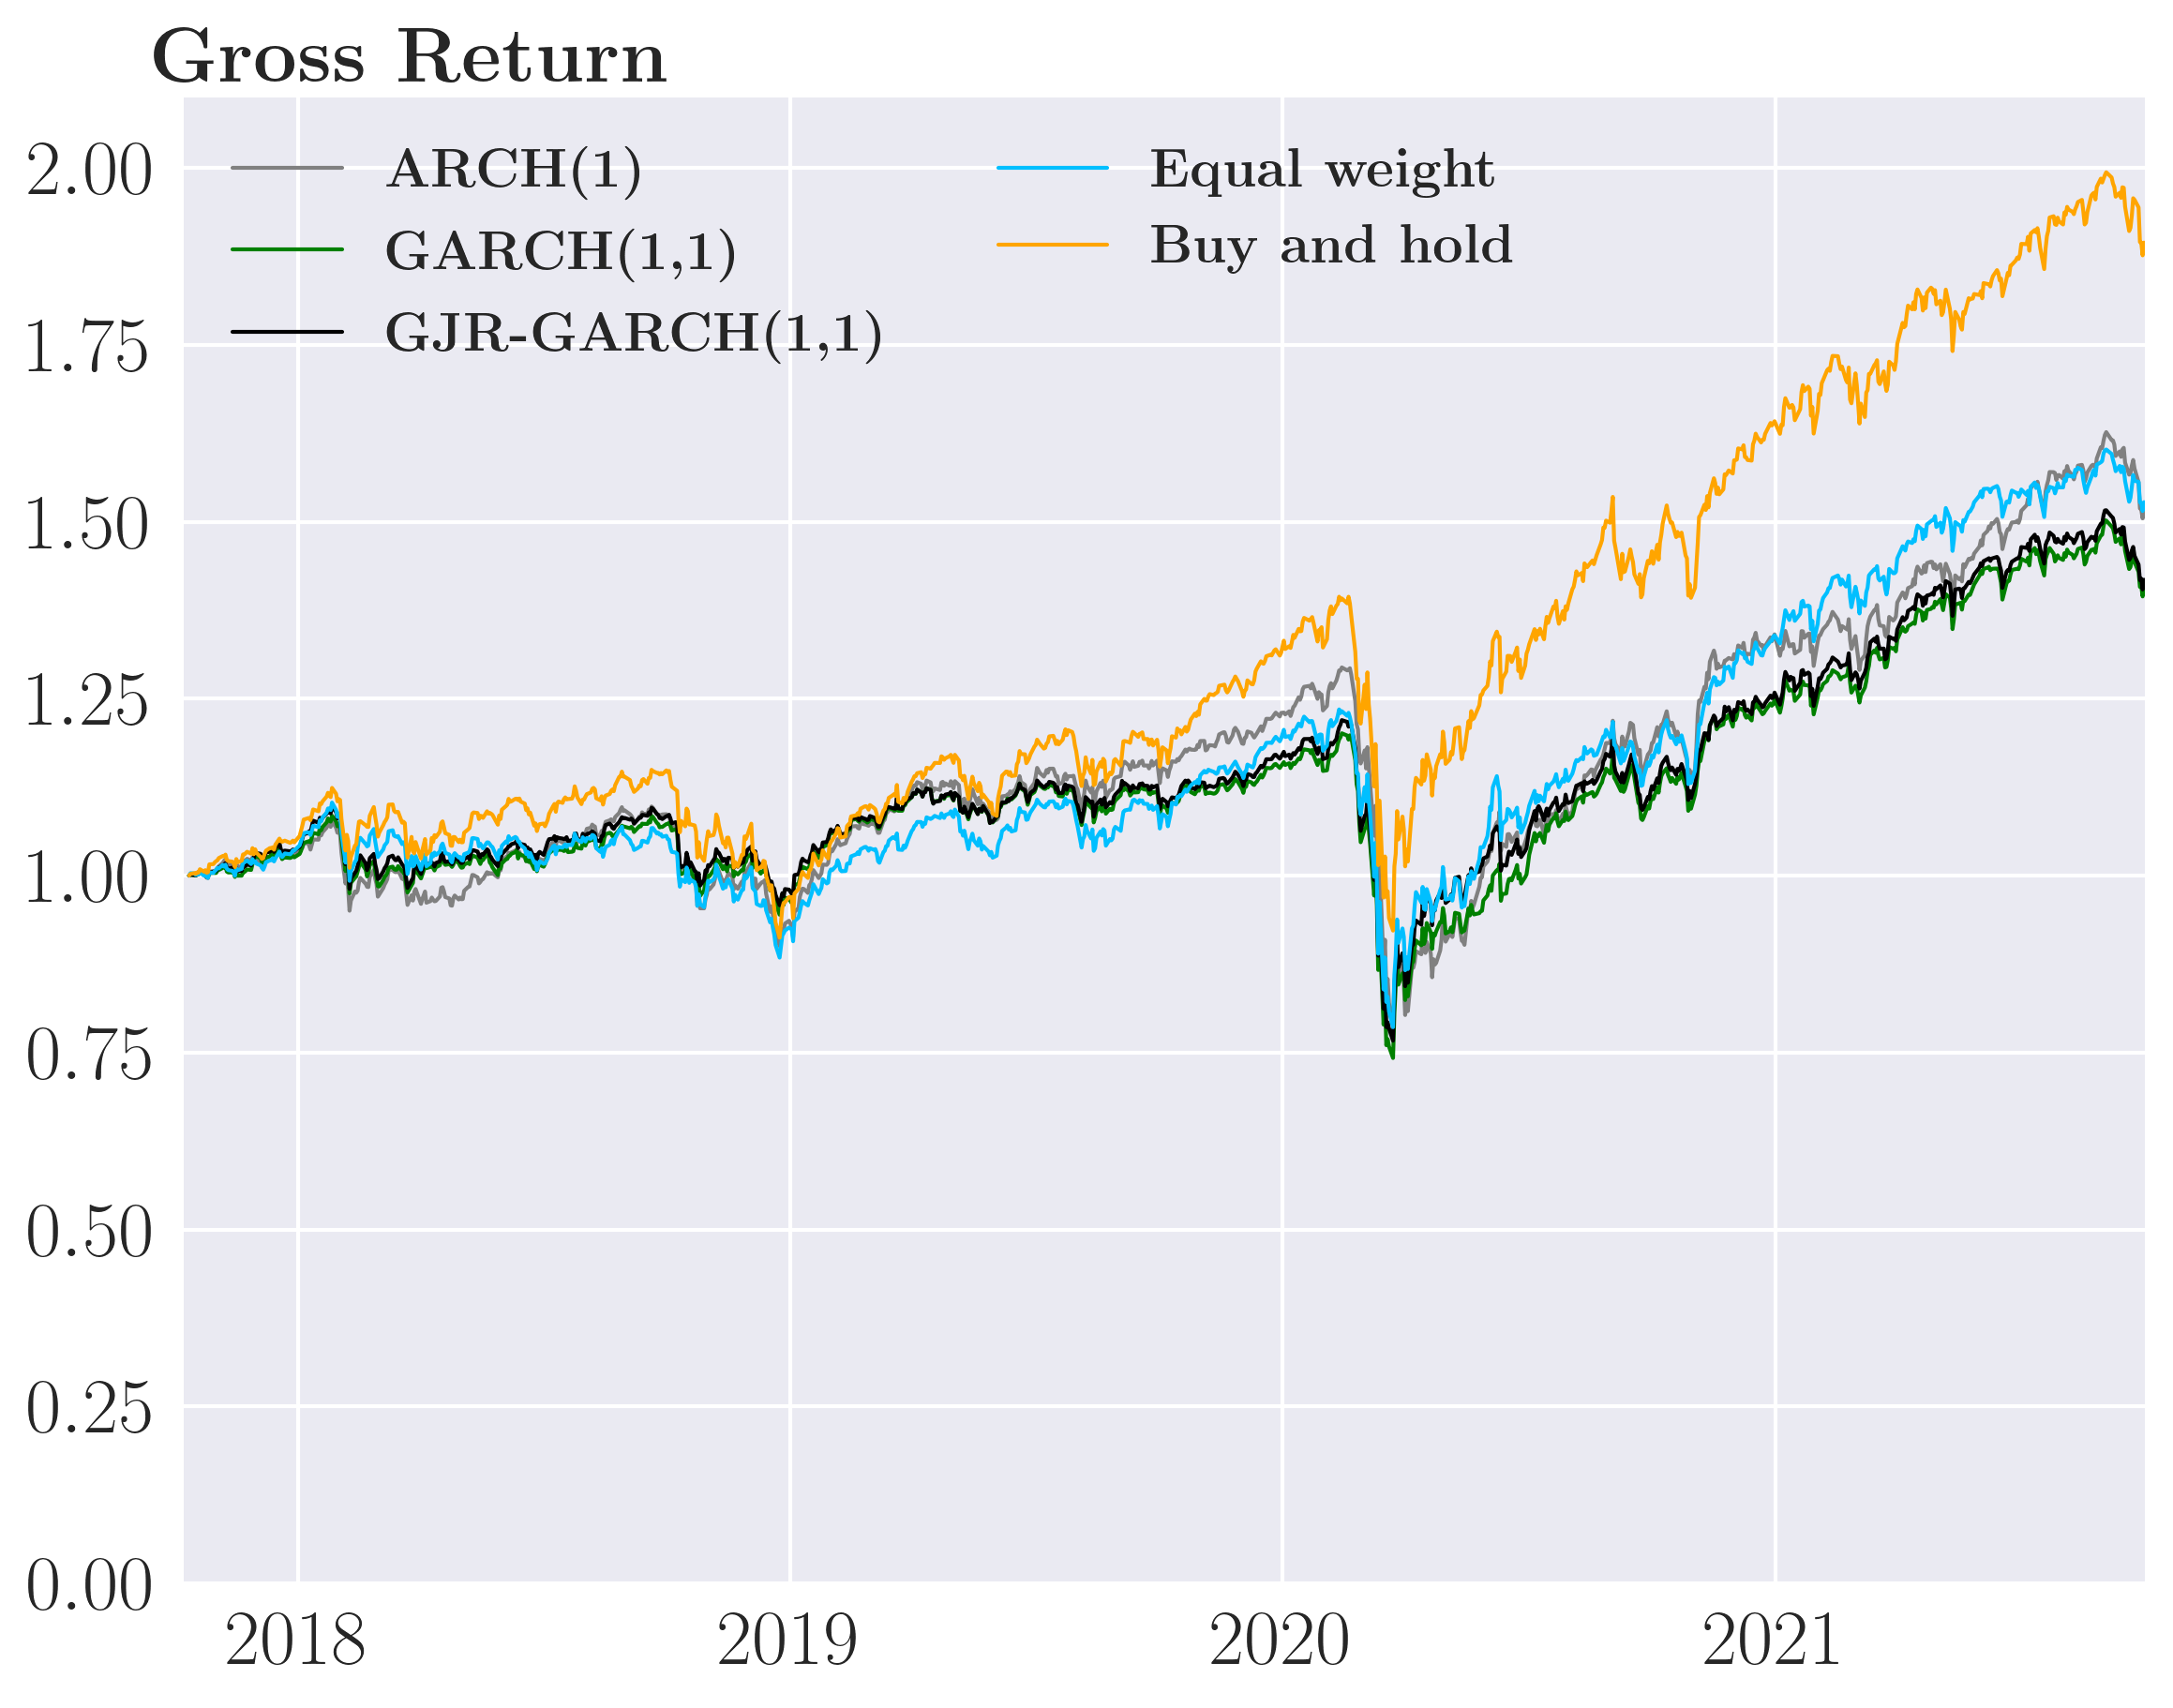

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(9,7), dpi=300)
ax.plot(res_s,linewidth=1)
ax.set_ylim(0,2.1)
ax.set_xlim("2017-10-08","2021-10-02")
ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
ax.legend([r'\textbf{ARCH(1)}',r'\textbf{GARCH(1,1)}',r'\textbf{GJR-GARCH(1,1)}',r'\textbf{Equal weight}',r'\textbf{Buy and hold}']
,ncol=2,loc="upper left",fontsize=14)
ax.set_ylabel(r'\textbf{Gross Return}',loc='top', rotation = 0, labelpad = -165) 
#fig.savefig("Backtesting\output\Performance_no_TC.png", bbox_inches = 'tight', pad_inches = 0.1)
fig.savefig("Performance_no_TC_before_S.png", bbox_inches = 'tight', pad_inches = 0.1)

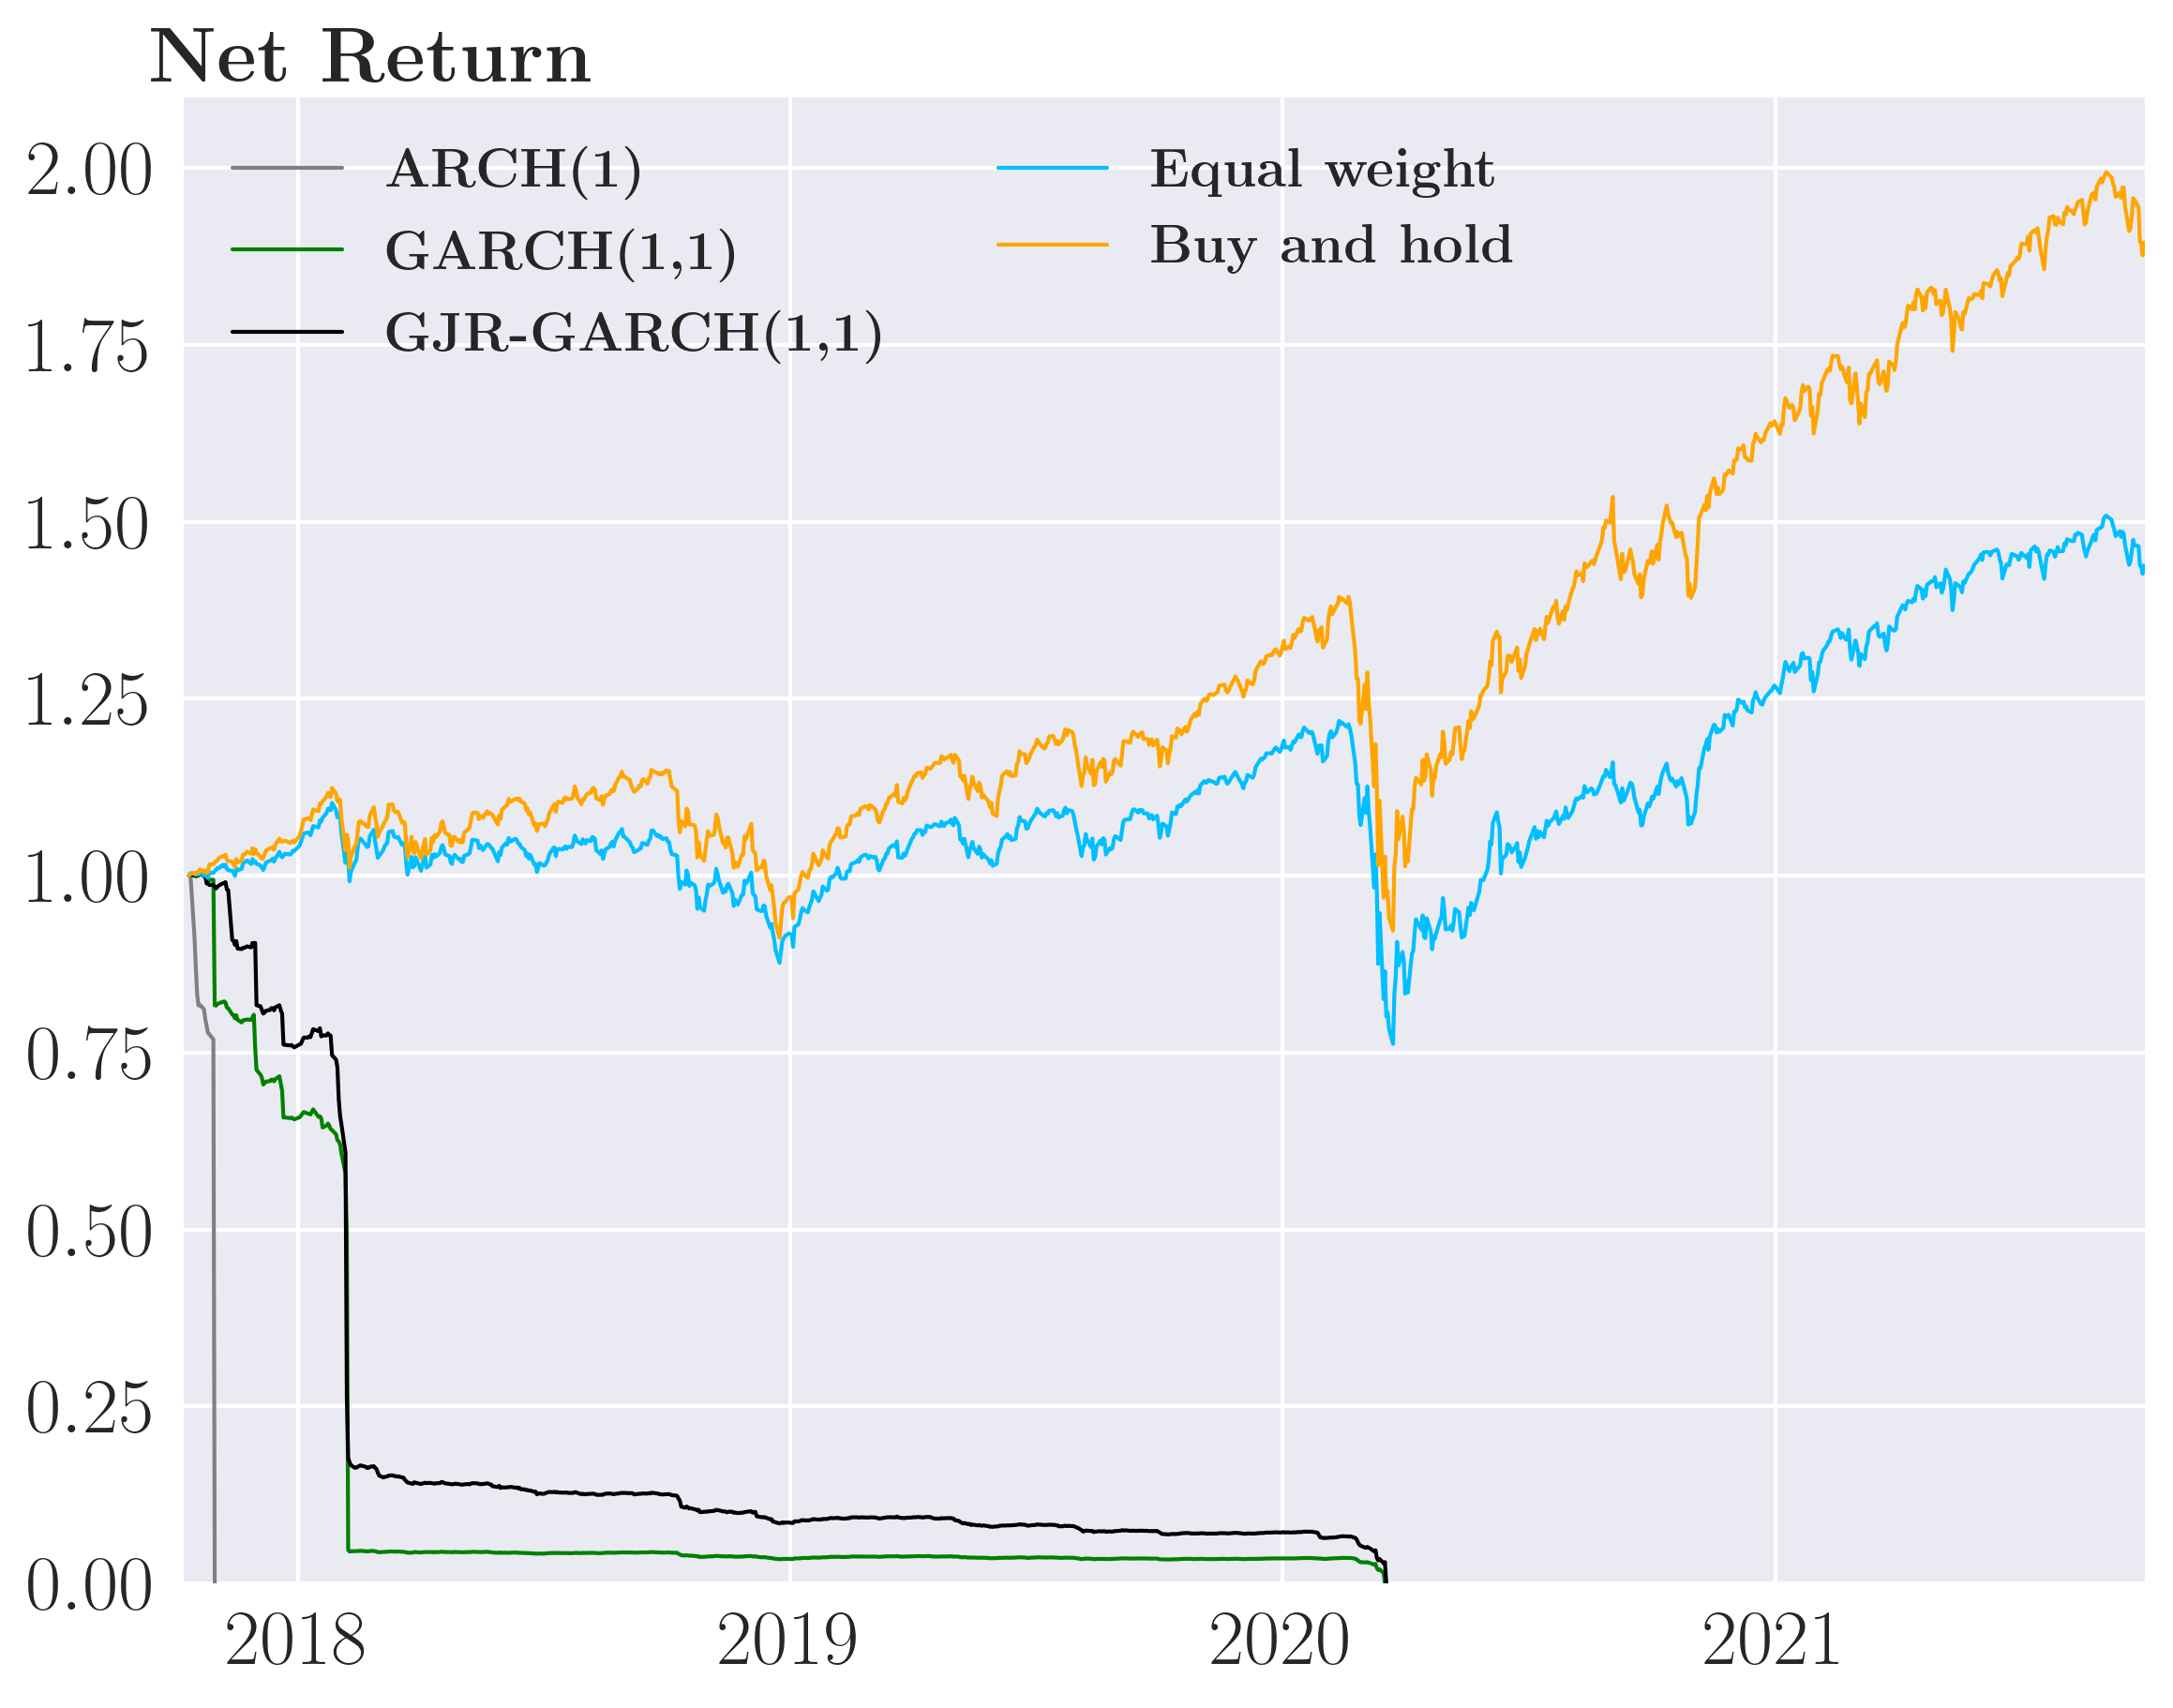

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(9,7), dpi=300)
ax.plot(res_TC_s,linewidth=1)
ax.set_ylim(0,2.1)
ax.set_xlim("2017-10-08","2021-10-02")
ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
ax.legend([r'\textbf{ARCH(1)}',r'\textbf{GARCH(1,1)}',r'\textbf{GJR-GARCH(1,1)}',r'\textbf{Equal weight}',r'\textbf{Buy and hold}']
,ncol=2,loc="upper left",fontsize=14)
ax.set_ylabel(r'\textbf{Net Return}',loc='top', rotation = 0, labelpad = -145)  
#fig.savefig("Backtesting\output\Performance_no_TC.png", bbox_inches = 'tight', pad_inches = 0.1)
fig.savefig("Performance_no_TC_after_S.png", bbox_inches = 'tight', pad_inches = 0.1)

In [ ]:
v_t_ARCH_s.index = pd.to_datetime(v_t_ARCH_s.index)
fig, ax = plt.subplots(1, 1, figsize=(9,7), dpi=300)
ax.plot(v_t_ARCH_s,linewidth=0.8)
ax.set_ylim(-0.5,1.5)
ax.set_xlim("2017-10-08","2021-10-02")
ax.legend([r"\textbf{Emerging Markets}",r"\textbf{S\&P 500}",r"\textbf{MSCI Europe}",r"\textbf{Global Tech}",r"\textbf{US Real Estate}"
,r"\textbf{Global Financials}",r"\textbf{Global Industrials}",r"\textbf{Gold Futures}",r"\textbf{Brent Crude Oil Futures}"
,r"\textbf{High-Yield Corporate Bonds}",r"\textbf{20+ Year Treasury Bonds}"],ncol=3,loc="upper left",fontsize=10.8)
ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
ax.set_ylabel(r'\textbf{Weight, $v_t$}',loc='top', rotation = 0, labelpad = -150) 
#fig.savefig("Backtesting\output\ARCH_weight_NO_TC_S.png", bbox_inches = 'tight', pad_inches = 0.1)
fig.savefig("ARCH_weight_NO_TC_S.png", bbox_inches = 'tight', pad_inches = 0.1)

In [ ]:
v_t_GARCH_s.index = pd.to_datetime(v_t_GARCH_s.index)
fig, ax = plt.subplots(1, 1, figsize=(9,7), dpi=300)
ax.plot(v_t_GARCH_s,linewidth=0.8)
ax.set_ylim(-0.5,1.5)
ax.set_xlim("2017-10-08","2021-10-02")
ax.legend([r"\textbf{Emerging Markets}",r"\textbf{S\&P 500}",r"\textbf{MSCI Europe}",r"\textbf{Global Tech}",r"\textbf{US Real Estate}"
,r"\textbf{Global Financials}",r"\textbf{Global Industrials}",r"\textbf{Gold Futures}",r"\textbf{Brent Crude Oil Futures}"
,r"\textbf{High-Yield Corporate Bonds}",r"\textbf{20+ Year Treasury Bonds}"],ncol=3,loc="upper left",fontsize=10.8)
ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
ax.set_ylabel(r'\textbf{Weight, $v_t$}',loc='top', rotation = 0, labelpad = -150) 
#fig.savefig("Backtesting\output\GARCH_weight_NO_TC_S.png", bbox_inches = 'tight', pad_inches = 0.1)
fig.savefig("GARCH_weight_NO_TC_S.png", bbox_inches = 'tight', pad_inches = 0.1)

In [ ]:
v_t_GJR_s.index = pd.to_datetime(v_t_GJR_s.index)
fig, ax = plt.subplots(1, 1, figsize=(9,7), dpi=300)
ax.plot(v_t_GJR_s,linewidth=0.8)
ax.set_ylim(-0.5,1.5)
ax.set_xlim("2017-10-08","2021-10-02")
ax.legend([r"\textbf{Emerging Markets}",r"\textbf{S\&P 500}",r"\textbf{MSCI Europe}",r"\textbf{Global Tech}",r"\textbf{US Real Estate}"
,r"\textbf{Global Financials}",r"\textbf{Global Industrials}",r"\textbf{Gold Futures}",r"\textbf{Brent Crude Oil Futures}"
,r"\textbf{High-Yield Corporate Bonds}",r"\textbf{20+ Year Treasury Bonds}"],ncol=3,loc="upper left",fontsize=10.8)
ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
ax.set_ylabel(r'\textbf{Weight, $v_t$}',loc='top', rotation = 0, labelpad = -150) 
#fig.savefig("Backtesting\output\GJRGARCH_weight_NO_TC_S.png", bbox_inches = 'tight', pad_inches = 0.1)
fig.savefig("GJRGARCH_weight_NO_TC_S.png", bbox_inches = 'tight', pad_inches = 0.1)